Author: Shan Qu, Delft University of Technology

First created: 4 April 2021; First modified: 7 April 2021

Product: data preprocessing + a basic risk modeling test (without feature selection, using only default hyperparameters), based on the following algorithms:
*   Logistic regression
*   CART tree
*   Random forest
*   XGBoost
*   SVM
*   Neural network




In [68]:
!pip install category_encoders
!pip install xgboost

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

pd.set_option('display.max_columns', 20)
seed = 143

In [69]:
df_data = pd.read_csv('Data/df_data.csv')
print(df_data.info())
N_data = len(df_data)

# drop the unnamed ID column
df_data.drop('Unnamed: 0', axis=1, inplace=True)

df_data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         1000 non-null   int64 
 1   checking_account   1000 non-null   object
 2   duration           1000 non-null   int64 
 3   credit_history     1000 non-null   object
 4   purpose            1000 non-null   object
 5   credit_amount      1000 non-null   int64 
 6   savings_account    1000 non-null   object
 7   employment_length  1000 non-null   object
 8   installment_rate   1000 non-null   int64 
 9   status_sex         1000 non-null   object
 10  other_debtors      1000 non-null   object
 11  residence_length   1000 non-null   int64 
 12  property           1000 non-null   object
 13  age                1000 non-null   int64 
 14  installment_plan   1000 non-null   object
 15  housing            1000 non-null   object
 16  existing_credits   1000 non-null   int64 
 

,checking_account,duration,credit_history,purpose,credit_amount,savings_account,employment_length,installment_rate,status_sex,other_debtors,...,property,age,installment_plan,housing,existing_credits,job,liable_people,telephone,foreign_worker,default
0,"[, 0)",6,other,radio_tv,1169,unknown,"[7, )",4,male_single,no,...,real_estate,67,no,own,2,skilled,1,registered,yes,good
1,"[0, 200)",48,exist_credit,radio_tv,5951,"[, 100)","[1, 4)",2,female_divorce_married,no,...,real_estate,22,no,own,1,skilled,1,no,yes,bad
2,no,12,other,education,2096,"[, 100)","[4, 7)",2,male_single,no,...,real_estate,49,no,own,1,unskilled_resident,2,no,yes,good
3,"[, 0)",42,exist_credit,furniture_equipment,7882,"[, 100)","[4, 7)",2,male_single,guarantor,...,insurance,45,no,free,1,skilled,2,no,yes,good
4,"[, 0)",24,delay_past,car_new,4870,"[, 100)","[1, 4)",3,male_single,no,...,unknown,53,no,free,2,skilled,2,no,yes,bad
5,no,36,exist_credit,education,9055,unknown,"[1, 4)",2,male_single,no,...,unknown,35,no,free,1,unskilled_resident,2,registered,yes,good
6,no,24,exist_credit,furniture_equipment,2835,"[500, 1000)","[7, )",3,male_single,no,...,insurance,53,no,own,1,skilled,1,no,yes,good
7,"[0, 200)",36,exist_credit,car_used,6948,"[, 100)","[1, 4)",2,male_single,no,...,car,35,no,rent,1,highly_skilled,1,registered,yes,good
8,no,12,exist_credit,radio_tv,3059,"[1000, )","[4, 7)",2,male_divorce,no,...,real_estate,61,no,own,1,unskilled_resident,1,no,yes,good
9,"[0, 200)",30,other,car_new,5234,"[, 100)",unemployed,4,male_married,no,...,car,28,no,own,2,highly_skilled,1,no,yes,bad


## 2. Data preprocessing

### 2.1 Encoding the categorical data

**Categorical Variable Encoders:**
* OneHotEncoder: performs one hot encoding, optional: of popular categories
* CountFrequencyEncoder: replaces categories by observation count or percentage
* OrdinalEncoder: replaces categories by numbers arbitrarily or ordered by target
* MeanEncoder: replaces categories by the target mean
* WoEEncoder: replaces categories by the weight of evidence
* PRatioEncoder: replaces categories by a ratio of probabilities
* DecisionTreeEncoder: replaces categories by predictions of a decision tree
* RareLabelEncoder: groups infrequent categories


**Overview:**  https://readthedocs.org/projects/feature-engine/downloads/pdf/latest/


In [94]:
df_X = df_data.iloc[:, 0:-1]
df_y = df_data.iloc[:, -1].replace({'good': 0, 'bad': 1})

#Use ordinal encoding for ordinal categorical variable:
# 'checking_account', 'savings_account', 'employment_length', 'job'
df_X['checking_account'] = df_X['checking_account'].replace(
    {'[, 0)': 0, '[0, 200)': 1, '[200, )': 2, 'no': 0})

df_X['savings_account'] = df_X['savings_account'].replace(
    {'[, 100)': 0, '[100, 500)': 1, '[500, 1000)': 2, '[1000, )': 3, 'unknown': 0})

df_X['employment_length'] = df_X['employment_length'].replace(
    {'unemployed': 0, '[, 1)': 1, '[1, 4)': 2, '[4, 7)': 3, '[7, )': 4})

df_X['job'] = df_X['job'].replace(
    {'unskilled_nonresident': 0, 'unskilled_resident': 1, 'skilled': 2, 'highly_skilled': 3})

df_X.describe()

# the rest categorical variables encoded using WOE
# Create two data sets for quantitative and qualitative data
df_X_mum = df_X.select_dtypes(exclude=['object'])
df_X_cat = df_X.select_dtypes(include=['object'])
print(df_X_cat.head())


#df_X_cat_new = ce.OneHotEncoder().fit_transform(df_X_cat, y=df_y)
#df_X_cat_new = ce.WOEEncoder().fit_transform(df_X_cat, y=df_y)
#df_X_cat_new = ce.cat_boost.CatBoostEncoder().fit_transform(df_X_cat, y=df_y)
#df_X_cat_new = ce.sum_coding.SumEncoder().fit_transform(df_X_cat, y=df_y)
df_X_cat_new = ce.james_stein.JamesSteinEncoder().fit_transform(df_X_cat, y=df_y)
df_X_prep = pd.concat([df_X_mum, df_X_cat_new], axis=1)

  credit_history              purpose              status_sex other_debtors  \
0          other             radio_tv             male_single            no   
1   exist_credit             radio_tv  female_divorce_married            no   
2          other            education             male_single            no   
3   exist_credit  furniture_equipment             male_single     guarantor   
4     delay_past              car_new             male_single            no   

      property installment_plan housing   telephone foreign_worker  
0  real_estate               no     own  registered            yes  
1  real_estate               no     own          no            yes  
2  real_estate               no     own          no            yes  
3    insurance               no    free          no            yes  
4      unknown               no    free          no            yes  


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


### 2.2 Scale the numerical data and check  the correlation map and feature importance 

In [95]:
df_X_prep[df_X_prep.columns] = MinMaxScaler().fit_transform(df_X_prep[df_X_prep.columns])
#df_X_mum[df_X_mum.columns] = MinMaxScaler().fit_transform(df_X_mum[df_X_mum.columns])

print(df_X_prep.columns)
df_X_prep.head()

Index(['checking_account', 'duration', 'credit_amount', 'savings_account',
       'employment_length', 'installment_rate', 'residence_length', 'age',
       'existing_credits', 'job', 'liable_people', 'credit_history', 'purpose',
       'status_sex', 'other_debtors', 'property', 'installment_plan',
       'housing', 'telephone', 'foreign_worker'],
      dtype='object')


,checking_account,duration,credit_amount,savings_account,employment_length,installment_rate,residence_length,age,existing_credits,job,liable_people,credit_history,purpose,status_sex,other_debtors,property,installment_plan,housing,telephone,foreign_worker
0,0.0,0.029412,0.050567,0.0,1.00,1.000000,1.000000,0.857143,0.333333,0.666667,0.0,0.000000,0.398140,0.000000,0.436055,0.000000,0.0,0.0,0.0,1.0
1,0.5,0.647059,0.313690,0.0,0.50,0.333333,0.333333,0.053571,0.000000,0.666667,0.0,0.343530,0.398140,0.642469,0.436055,0.000000,0.0,0.0,1.0,1.0
2,0.0,0.117647,0.101574,0.0,0.75,0.333333,0.666667,0.535714,0.000000,0.333333,1.0,0.000000,1.000000,0.000000,0.436055,0.000000,0.0,0.0,1.0,1.0
3,0.0,0.558824,0.419941,0.0,0.75,0.333333,1.000000,0.464286,0.000000,0.666667,1.0,0.343530,0.687522,0.000000,0.000000,0.428748,0.0,1.0,1.0,1.0
4,0.0,0.294118,0.254209,0.0,0.50,0.666667,1.000000,0.607143,0.333333,0.666667,1.0,0.341977,0.847117,0.000000,0.436055,1.000000,0.0,1.0,1.0,1.0


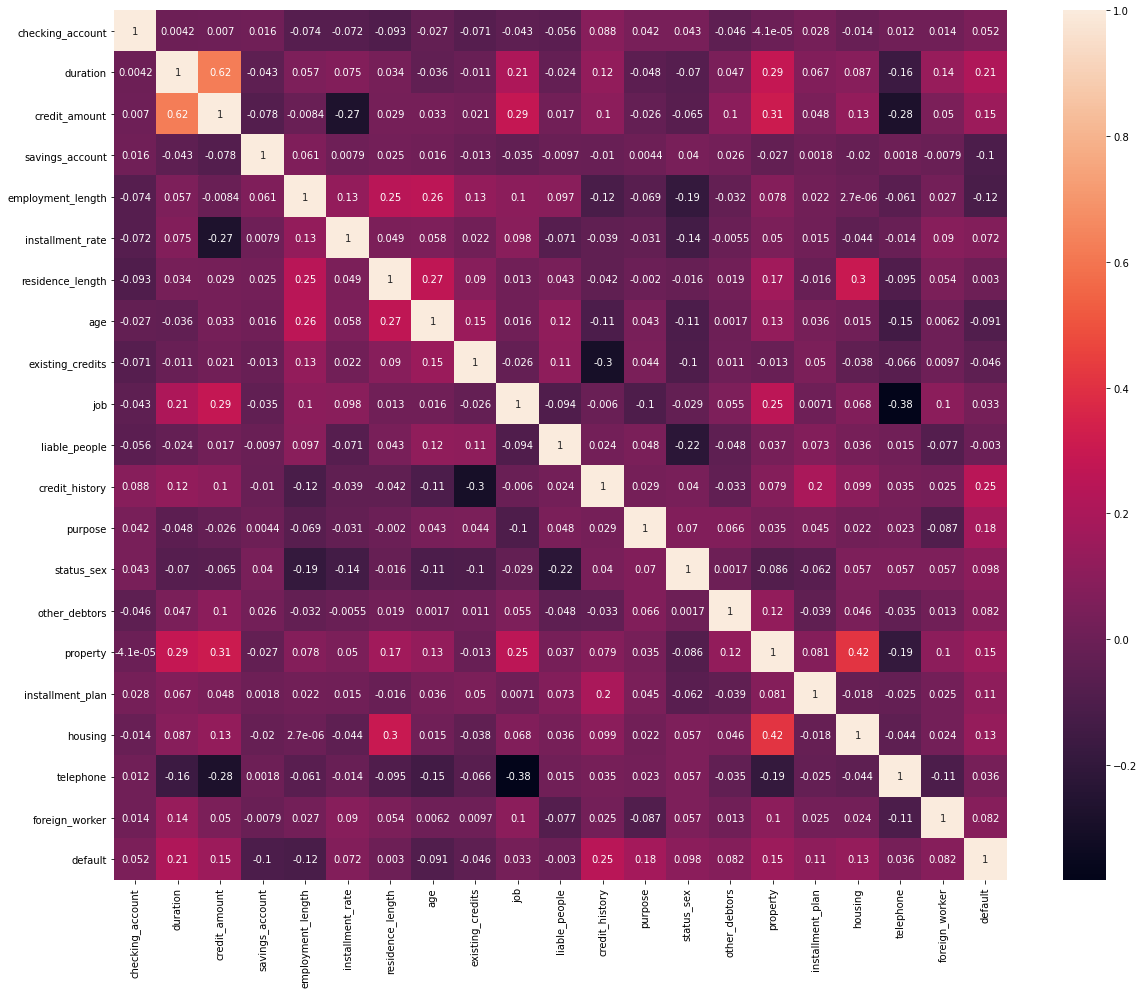

In [96]:
df_X_y = pd.concat([df_X_prep.reset_index(drop = True), df_y.reset_index(drop = True)], axis = 1)
plt.figure(figsize=(20,16))
sns.heatmap(df_X_y.astype(float).corr(), annot=True)
plt.show()

{'credit_history': 48, 'duration': 73, 'credit_amount': 136, 'age': 71, 'housing': 21, 'purpose': 55, 'employment_length': 33, 'installment_plan': 18, 'checking_account': 25, 'property': 23, 'job': 14, 'savings_account': 15, 'existing_credits': 9, 'installment_rate': 15, 'status_sex': 25, 'other_debtors': 13, 'foreign_worker': 11, 'residence_length': 15, 'telephone': 12, 'liable_people': 1}


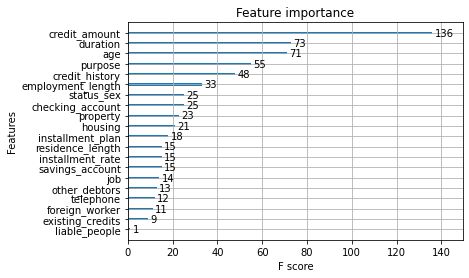

In [97]:
# quick check for the importance of features via XGBoost
clf_gbt = XGBClassifier().fit(df_X_prep,np.ravel(df_y))

# Print the column importances from the model
print(clf_gbt.get_booster().get_score(importance_type = 'weight'))
# Plot the column importance for this model
plot_importance(clf_gbt, importance_type = 'weight')
plt.show()

### 2.3 Divide the data into train and validation data

In [98]:
df_X_train, df_X_val, df_y_train, df_y_val = train_test_split(df_X_prep, df_y, test_size=.2, random_state=seed)

### 2.4 Deal with class imbalance in the data

* Gather more data
* Up-sample minority class
* Down-sample majority class
* Penalize Algorithms
For XGBoost, log-loss is used, therefore, the class imbalance is not a bit problem. However, false negative (default predicted as non-default) has more negative financial impact and this cannot be handled by XGBoost

In [99]:
df_X_y_train = pd.concat([df_X_train.reset_index(drop = True), df_y_train.reset_index(drop = True)], axis = 1)
nondefaults = df_X_y_train[df_X_y_train['default'] == 0]
defaults = df_X_y_train[df_X_y_train['default'] == 1]
count_nondefault, count_default = df_X_y_train['default'].value_counts()

# Undersample the non-defaults
nondefaults_under = nondefaults.sample(count_default)

# Concatenate the undersampled nondefaults with defaults
df_X_y_train = pd.concat([nondefaults_under.reset_index(drop = True),
                             defaults.reset_index(drop = True)], axis = 0)

df_X_train = df_X_y_train.iloc[:, 0:-1]
df_y_train = df_X_y_train.iloc[:, -1]
print(df_X_train.columns)

Index(['checking_account', 'duration', 'credit_amount', 'savings_account',
       'employment_length', 'installment_rate', 'residence_length', 'age',
       'existing_credits', 'job', 'liable_people', 'credit_history', 'purpose',
       'status_sex', 'other_debtors', 'property', 'installment_plan',
       'housing', 'telephone', 'foreign_worker'],
      dtype='object')


### 2.5 Write the data out for the next step --- Training with different models

In [100]:
df_X_train.to_csv('df_X_train.csv')
df_X_val.to_csv('df_X_val.csv')
df_y_train.to_csv('df_y_train.csv')
df_y_val.to_csv('df_y_val.csv')

### 2.6 An overview of credit modeling using different models with only default parameters

Training using different algorithms and compare the cross-validation scores, classification report, confusion matrix, AUC(area under curve) scores, and ROC curves
* Logistic_regression
* CART_tree
* Random_forest
* XGBoost
* SVM
* NN

In [101]:
df_training = pd.DataFrame.from_dict({'names': ['Logistic_regression'
    , 'CART_tree', 'Random_forest', 'XGBoost', 'SVM', 'NN']
    , 'models': [LogisticRegression(solver='lbfgs', max_iter=300)
    , DecisionTreeClassifier(), RandomForestClassifier(), XGBClassifier()
    , SVC(), MLPClassifier()]})

df_training

,names,models
0,Logistic_regression,"LogisticRegression(C=1.0, class_weight=None, d..."
1,CART_tree,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
2,Random_forest,"RandomForestClassifier(bootstrap=True, ccp_alp..."
3,XGBoost,"XGBClassifier(base_score=0.5, booster='gbtree'..."
4,SVM,"SVC(C=1.0, break_ties=False, cache_size=200, c..."
5,NN,"MLPClassifier(activation='relu', alpha=0.0001,..."


Computing cross-validated metrics for  Logistic_regression
Computing cross-validated metrics for  CART_tree
Computing cross-validated metrics for  Random_forest
Computing cross-validated metrics for  XGBoost
Computing cross-validated metrics for  SVM
Computing cross-validated metrics for  NN


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


                 names                                             models  \
0  Logistic_regression  LogisticRegression(C=1.0, class_weight=None, d...   
1            CART_tree  DecisionTreeClassifier(ccp_alpha=0.0, class_we...   
2        Random_forest  RandomForestClassifier(bootstrap=True, ccp_alp...   
3              XGBoost  XGBClassifier(base_score=0.5, booster='gbtree'...   
4                  SVM  SVC(C=1.0, break_ties=False, cache_size=200, c...   
5                   NN  MLPClassifier(activation='relu', alpha=0.0001,...   

                                   cv_score_overview  
0  [0.701140873015873, 0.7328869047619048, 0.7951...  
1  [0.527281746031746, 0.5984623015873016, 0.5555...  
2  [0.6452132936507936, 0.7140376984126985, 0.746...  
3  [0.6448412698412699, 0.7018849206349207, 0.735...  
4  [0.7011408730158729, 0.72296626984127, 0.81078...  
5  [0.6748511904761904, 0.7180059523809526, 0.803...  


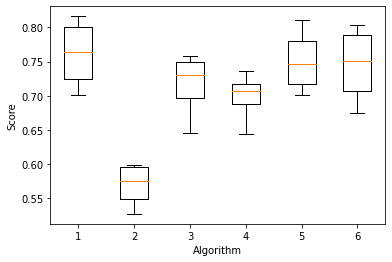

In [103]:
def false_negative_scorer(clf, X, y):
  y_pred = clf.predict(X)
  cm = confusion_matrix(y, y_pred)
  return cm[1, 0]

#scoring_method = 'f1'
#scoring_method = 'recall'
scoring_method = 'roc_auc'

ls_score = []
for index in np.arange(len(df_training)):
  print("Computing cross-validated metrics for ", df_training.iloc[index, 0])
  #print(df_training.iloc[index, 1])
  score = cross_val_score(df_training.iloc[index, 1], df_X_train, np.ravel(df_y_train), cv=4, scoring=scoring_method)
  ls_score.append(score)

df_training['cv_score_overview'] = ls_score
print(df_training)

plt.boxplot(df_training['cv_score_overview'])
plt.xlabel('Algorithm')
plt.ylabel('Score')
plt.show()